## Setup

### Initial Imports, Path and Global Variable Definitions

In [1]:
import sys, datetime
import numpy as np
from scipy.optimize import curve_fit
import astrostat

projDir = "/Users/erwin/Documents/Working/Projects/Project_BarSizes/"
sys.path.append("/Users/erwin/Documents/Working/Projects/Project_BarSizes")
from datasets import s4gdata
import fitting_barsizes
nDisksTotal = len(s4gdata.name)

fitDict = {}

#### Setup for plotting

In [2]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

# kludge to fix matplotlib's font_manager bug which mistakenly ID's "Times New Roman Bold.ttf" as
# indicating a "roman" (i.e., "normal") weight
try:
    del matplotlib.font_manager.weight_dict['roman']
except KeyError:
    pass
matplotlib.font_manager._rebuild()

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# %load plot_label_defs.py
# useful definitions for printing and plotting labels

xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xtRe_kpc = r"Galaxy half-light radius $R_{e}$ [kpc]"
xtfgas = r"$\log \: (M_{\rm HI} / M_{\star})$"
xtHtype = r"Hubble Type $T$"
ytbarsize_kpc = r"Bar size $a_{\rm vis}$ [kpc]"
ytresid = r"Residuals: $\log \, (a_{\rm vis}) - \log \, ({\rm predicted})$"
ytresid_Re = r"Residuals: $\log \, R_{e, {\rm obs}} - \log \, ({\rm predicted})$"
ytresid_h = r"Residuals: $\log \, h - \log \, ({\rm predicted})$"


### Define Subsamples via Indices Lists

**Location of subsample definitions:** 

/Users/erwin/Documents/Working/Projects/Project_BarSizes/sample_defs.py

In [4]:
from sample_defs import *

For reference, here are the definitions:

In [5]:

# general subsamples: all barred, all unbarred, all spirals
# ii_barred = [i for i in range(nDisksTotal) if s4gdata.sma[i] > 0]
# ii_unbarred = [i for i in range(nDisksTotal) if s4gdata.sma[i] <= 0]
# ii_spirals = [i for i in range(nDisksTotal) if s4gdata.t_s4g[i] > -0.5]


# Limited subsample 2: spirals with D < 30 Mpc -- 856 galaxies: 483 barred, 373 unbarred
# ii_all_limited2 = [i for i in ii_spirals if s4gdata.dist[i] <= 30]
# ii_barred_limited2 = [i for i in ii_all_limited2 if i in ii_barred]
# ii_unbarred_limited2 = [i for i in ii_all_limited2 if i not in ii_barred]

# Parent Spiral Sample: limited subsample 2 + logMstar = 9--11:
# ii_all_limited2_m9to11 = [i for i in ii_all_limited2 if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11]
# ii_barred_limited2_m9to11 = [i for i in ii_all_limited2_m9to11 if i in ii_barred]



# Spirals with R_e *and* h
# ii_all_Reh = [i for i in ii_spirals if s4gdata.Re_kpc[i] > 0 and s4gdata.h_kpc[i] > 0]
# ii_barred_Reh = [i for i in ii_all_Reh if i in ii_barred]
# ii_unbarred_Reh = [i for i in ii_all_Reh if i not in ii_barred]


# Main Spiral Sample: Spirals with D < 30 Mpc, valid R_e *and* h, *and* logMstar = 9--11:
# ii_all_Reh_m9to11 = [i for i in ii_spirals if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11 and s4gdata.Re_kpc[i] > 0 and s4gdata.h_kpc[i] > 0]
# ii_barred_Reh_m9to11 = [i for i in ii_all_Reh_m9to11 if i in ii_barred]
# ii_unbarred_Reh_m9to11 = [i for i in ii_all_Reh_m9to11 if i not in ii_barred]

# ii_all_limited2_Reh = [i for i in ii_all_Reh if s4gdata.dist[i] <= 30]
# ii_barred_limited2_Reh = [i for i in ii_all_limited2_Reh if i in ii_barred]
# ii_unbarred_limited2_Reh = [i for i in ii_all_limited2_Reh if i not in ii_barred]

# ii_all_lim2m9to11_Reh = [i for i in ii_all_limited2_Reh if s4gdata.logmstar[i] >= 9 and s4gdata.logmstar[i] <= 11]
# ii_barred_lim2m9to11_Reh = [i for i in ii_all_lim2m9to11_Reh if i in ii_barred]
# ii_unbarred_lim2m9to11_Reh = [i for i in ii_all_lim2m9to11_Reh if i not in ii_barred]

# useful aliases which are more directly descriptive
# ii_all_D30 = ii_all_limited2
# ii_all_D30_m9to11 = ii_all_limited2_m9to11
# ii_barred_D30_m9to11 = ii_barred_limited2_m9to11
# ii_barred_D30_m9to11_Reh = ii_barred_lim2m9to11_Reh

### Define Data Vectors for Subsamples

In [6]:
logmstar2 = s4gdata.logmstar[ii_barred_limited2_m9to11]
logmstar2_Reh = s4gdata.logmstar[ii_barred_lim2m9to11_Reh]
logfgas2_Reh = s4gdata.logfgas[ii_barred_lim2m9to11_Reh]

# R_e and h
logRe_all = np.log10(s4gdata.Re_kpc)
logh_all = np.log10(s4gdata.h_kpc)

logRe2_Reh = np.log10(s4gdata.Re_kpc[ii_barred_lim2m9to11_Reh])
logh2_Reh = np.log10(s4gdata.h_kpc[ii_barred_lim2m9to11_Reh])

# deprojected bar sizes for same subsamples [note that unbarred galaxies will end up with -inf for
# the log of their bar size]
logbarsize_dp2_all = np.log10(s4gdata.sma_dp_kpc2)
logbarsize_dp2 = np.log10(s4gdata.sma_dp_kpc2[ii_barred_limited2_m9to11])
logbarsize_dp2_Reh = np.log10(s4gdata.sma_dp_kpc2[ii_barred_lim2m9to11_Reh])

nData2 = len(logmstar2)
nData2_Reh = len(logmstar2_Reh)

# constant 10% errors for bar sizes
logbarsize_dp2_all_errs10 = np.zeros(nDisksTotal) + 0.044
logbarsize_dp2_errs10 = np.zeros(nData2) + 0.044
logbarsize_dp2_Reh_errs10 = np.zeros(nData2_Reh) + 0.044


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


#### Spearman Correlation Coefficients

In [7]:
astrostat.spearmanr(logRe_all[ii_barred_lim2m9to11_Reh], logbarsize_dp2_all[ii_barred_lim2m9to11_Reh])

(0.5642579835735413, 3.0702429310743564e-32)

In [8]:
astrostat.spearmanr(logh_all[ii_barred_lim2m9to11_Reh], logbarsize_dp2_all[ii_barred_lim2m9to11_Reh])

(0.6125412943459034, 3.575040425796504e-39)

In [9]:
astrostat.spearmanr(s4gdata.t_leda[ii_barred_lim2m9to11_Reh], logbarsize_dp2_all[ii_barred_lim2m9to11_Reh])

(-0.17641910775081038, 0.0006866883775508268)

### Define Functions for Fitting (+ log-likelihood)

In [11]:
# Define additional functions for plots (mainly for sanity-checking)

def PlotFit( x, y, ii, x_model, modelFunc, params, ms_data=6 ):
    plot(x[ii], y[ii], 'o', color='0.5', ms=ms_data)
    y_model = modelFunc(x_model, *params)
    plot(x_model, y_model, 'r', lw=2)


### Define Functions for MSE from Bootstrap Validation

In [14]:
# wrappers for functions from above, in form needed by astrostat.bootstrap_validation

def nicelin( x, p ):
    return fitting_barsizes.flin(x, *p)

def dofit_lin( x, y, p0, errs ):
    pp,pcov = curve_fit(fitting_barsizes.flin, x, y, p0=p0, sigma=errs)
    return pp

def nicebrokenlin( x, p ):
    return fitting_barsizes.fbrokenlin(x, *p)

def dofit_brokenlin( x, y, p0, errs ):
    pp,pcov = curve_fit(fitting_barsizes.fbrokenlin, x, y, p0=p0, sigma=errs)
    return pp


def nicecomposite( x, p ):
    return fitting_barsizes.fmulti_lin_brokenlin(x, *p)

def dofit_composite( x, y, p0, errs ):
    pp,pcov = curve_fit(fitting_barsizes.fmulti_lin_brokenlin, x, y, p0=p0, sigma=errs)
    return pp


def nicecomposite_binary( x, p ):
    return fitting_barsizes.fmulti_binary(x, *p)

def dofit_composite_binary( x, y, p0, errs ):
    pp,pcov = curve_fit(fitting_barsizes.fmulti_binary, x, y, p0=p0, sigma=errs)
    return pp


## Fits: Subsample 2 (Barsize vs logMstar)

### Barsize vs logMstar: Linear and Broken-linear

In [31]:
p0_lin = [-2, 0.3]
p0_brokenlin = [-0.7, 0.1, 10.1, 0.6]

xx,yy = s4gdata.logmstar, logbarsize_dp2_all
errs = logbarsize_dp2_all_errs10
iii = ii_barred_D30_m9to11_Reh
iii_parent = ii_barred_D30_m9to11

print("Linear fit: barsize vs logMstar:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_lin)
pp_mstar_lin10,aic_mstar_lin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_lin, computeModelFn=nicelin, initialParams=pp_mstar_lin10, errs=errs[iii], verbose=True)
fitDict['barsize-vs-Mstar_lin'] = [pp_mstar_lin10,aic_mstar_lin10,mse]
fitDict['barsize-vs-Mstar_lin_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_mstar_lin10, nIterations=2000) 

print("\nBroken-linear fit: barsize vs logMstar:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_brokenlin, "broken-linear")
pp_mstar_brokenlin10,aic_mstar_brokenlinlin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_brokenlin, computeModelFn=nicebrokenlin, initialParams=pp_mstar_brokenlin10, errs=errs[iii], verbose=True)
fitDict['barsize-vs-Mstar_brokenlin'] = [pp_mstar_brokenlin10,aic_mstar_brokenlinlin10,mse]
fitDict['barsize-vs-Mstar_brokenlin_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_mstar_brokenlin10, nIterations=2000, mode="broken-linear") 

print("\nDelta_AIC = %g" % (aic_mstar_brokenlinlin10 - aic_mstar_lin10))

# parent sample barsize-vs-Mstar_parent_brokenlin
print("\nBroken-linear fit: barsize vs logMstar (Parent Spiral Sample):")
x = fitting_barsizes.DoFit(xx,yy, errs, iii_parent, p0_brokenlin, "broken-linear")
pp_mstar_parent_brokenlin10,aic_mstar_parent_brokenlinlin10 = x
mse = astrostat.bootstrap_validation(xx[iii_parent], yy[iii_parent], 1000, dofit_brokenlin, computeModelFn=nicebrokenlin, initialParams=pp_mstar_parent_brokenlin10, errs=errs[iii_parent], verbose=True)
fitDict['barsize-vs-Mstar_parent_brokenlin'] = [pp_mstar_parent_brokenlin10,aic_mstar_parent_brokenlinlin10,mse]
fitDict['barsize-vs-Mstar_parent_brokenlin_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii_parent, pp_mstar_parent_brokenlin10, nIterations=2000, mode="broken-linear") 


Linear fit: barsize vs logMstar:
   alpha, beta = [-1.84873, 0.219618]
   AIC = 8519.97
[-1.84873352  0.21961791]
training MSE = 0.0449233
test MSE = 0.0454237 (1000 successful iterations)
Adjusted test MSE = 0.0452395

Broken-linear fit: barsize vs logMstar:
alpha1, beta1, alpha2, beta2, x_break = 
[-0.417, 0.069, -5.377, 0.559, 10.109]
   AIC = 7870.11
[-0.41718187  0.06879514 10.10900102  0.55938316]
training MSE = 0.0414736
test MSE = 0.0426852 (1000 successful iterations)
Adjusted test MSE = 0.0422394

Delta_AIC = -649.858

Broken-linear fit: barsize vs logMstar (Parent Spiral Sample):
alpha1, beta1, alpha2, beta2, x_break = 
[-0.657, 0.095, -5.700, 0.591, 10.162]
   AIC = 8560.73
[-0.65703145  0.09510115 10.16199937  0.59132854]
training MSE = 0.0427852
test MSE = 0.0441197 (1000 successful iterations)
Adjusted test MSE = 0.0436286


#### Test Plot

(9.0, 11.0)

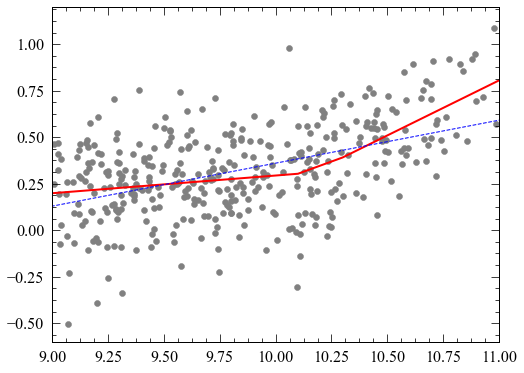

In [16]:
#PlotFit( x, y, x_model, modelFunc, params ):
mm = np.arange(8.5,11.5,0.2)
PlotFit(xx, yy, ii_barred_limited2_m9to11, mm, fbrokenlin, pp_mstar_brokenlin10)
plot(mm, flin(mm, *pp_mstar_lin10), 'b--')
xlim(9.0,11.0)

## Fits: Subsample 2_Reh

### Barsize vs logMstar (Linear and Broken-linear)

In [18]:
p0_lin = [-2, 0.3]
p0_brokenlin = [-0.7, 0.1, 10.1, 0.6]

xx,yy = s4gdata.logmstar, logbarsize_dp2_all
errs = logbarsize_dp2_all_errs10
iii = ii_barred_lim2m9to11_Reh

print("Linear fit: barsize vs logMstar:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_lin)
pp_mstar_Reh_lin10,aic_mstar_Reh_lin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_lin, computeModelFn=nicelin, initialParams=pp_mstar_Reh_lin10, errs=errs[iii], verbose=True)
fitDict['barsize-vs-Mstar_lin_Reh'] = [pp_mstar_Reh_lin10,aic_mstar_Reh_lin10,mse]
fitDict['barsize-vs-Mstar_lin_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_mstar_Reh_lin10, nIterations=2000) 

print("\nBroken-linear fit: barsize vs logMstar:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_brokenlin, "broken-linear")
pp_mstar_Reh_brokenlin10,aic_mstar_Reh_brokenlinlin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_brokenlin, computeModelFn=nicebrokenlin, initialParams=pp_mstar_Reh_brokenlin10, errs=errs[iii], verbose=True)
fitDict['barsize-vs-Mstar_brokenlin_Reh'] = [pp_mstar_Reh_brokenlin10,aic_mstar_Reh_brokenlinlin10,mse]
fitDict['barsize-vs-Mstar_brokenlin_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_mstar_Reh_brokenlin10, nIterations=2000, mode="broken-linear") 

print("\nDelta_AIC = %g" % (aic_mstar_Reh_brokenlinlin10 - aic_mstar_Reh_lin10))

Linear fit: barsize vs logMstar:
   alpha, beta = [-1.84873, 0.219618]
   AIC = 8519.97
[-1.84873352  0.21961791]
training MSE = 0.0449233
test MSE = 0.0456236 (1000 successful iterations)
Adjusted test MSE = 0.0453659

Broken-linear fit: barsize vs logMstar:
alpha1, beta1, alpha2, beta2, x_break = 
[-0.417, 0.069, -5.377, 0.559, 10.109]
   AIC = 7870.11
[-0.41718187  0.06879514 10.10900102  0.55938316]
training MSE = 0.0414736
test MSE = 0.0428408 (1000 successful iterations)
Adjusted test MSE = 0.0423377

Delta_AIC = -649.858


### Barsize vs log R_e, vs log h, and vs log(f_gas) (Linear)

In [19]:
p0_lin = [0.5, 0.2]
errs = logbarsize_dp2_all_errs10
iii = ii_barred_lim2m9to11_Reh


xx,yy = logRe_all, logbarsize_dp2_all
print("Linear fit: barsize vs log(R_e):")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_lin)
pp_Re_lin10,aic_Re_lin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_lin, computeModelFn=nicelin, initialParams=pp_Re_lin10, errs=errs[iii], verbose=True)
fitDict['barsize-vs-Re_lin_Reh'] = [pp_Re_lin10,aic_Re_lin10,mse]
fitDict['barsize-vs-Re_lin_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_Re_lin10, nIterations=2000) 

xx,yy = logh_all, logbarsize_dp2_all
print("\nLinear fit: barsize vs log(h):")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_lin)
pp_h_lin10,aic_h_lin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_lin, computeModelFn=nicelin, initialParams=pp_h_lin10, errs=errs[iii], verbose=True)
fitDict['barsize-vs-h_lin_Reh'] = [pp_h_lin10,aic_h_lin10,mse]
fitDict['barsize-vs-h_lin_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_h_lin10, nIterations=2000) 

xx,yy = s4gdata.logfgas, logbarsize_dp2_all
print("\nLinear fit: barsize vs log(f_gas):")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_lin)
pp_fgas_lin10,aic_fgas_lin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_lin, computeModelFn=nicelin, initialParams=pp_fgas_lin10, errs=errs[iii], verbose=True)
fitDict['barsize-vs-fgas_lin_Reh'] = [pp_fgas_lin10,aic_fgas_lin10,mse]
fitDict['barsize-vs-fgas_lin_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_fgas_lin10, nIterations=2000) 


Linear fit: barsize vs log(R_e):
   alpha, beta = [0.032746, 0.451161]
   AIC = 7328.84
[0.03274596 0.45116062]
training MSE = 0.0386399
test MSE = 0.0400003 (1000 successful iterations)
Adjusted test MSE = 0.0394996

Linear fit: barsize vs log(h):
   alpha, beta = [0.0377121, 0.758302]
   AIC = 6242.24
[0.03771213 0.75830204]
training MSE = 0.0329078
test MSE = 0.0337354 (1000 successful iterations)
Adjusted test MSE = 0.0334308

Linear fit: barsize vs log(f_gas):
   alpha, beta = [0.305877, -2.26877e-05]
   AIC = 10794.1
[ 3.05876540e-01 -2.26876803e-05]
training MSE = 0.0569198
test MSE = 0.0707442 (1000 successful iterations)
Adjusted test MSE = 0.0656568


### Barsize vs broken-linear logMstar + log R_e or broken-linear logMstar + log h

In [20]:
reload(fitting_barsizes)
p02 = [0, 0.5, 0, 0.0, 10.0, 0.5]
errs = logbarsize_dp2_all_errs10
iii = ii_barred_lim2m9to11_Reh

xx,yy = [logRe_all,s4gdata.logmstar], logbarsize_dp2_all
print("Composite fit: barsize vs log(R_e) + logMstar(broken-linear):")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p02, "composite")
pp_ReMstar_lin10,aic_ReMstar_lin10 = x
xx_composite = [logRe_all[iii],s4gdata.logmstar[iii]]
mse = astrostat.bootstrap_validation(xx_composite, yy[iii], 1000, dofit_composite, computeModelFn=nicecomposite, initialParams=p02, errs=errs[iii], verbose=True)
fitDict['barsize-vs-Re+Mstar_Reh'] = [pp_ReMstar_lin10,aic_ReMstar_lin10,mse]
fitDict['barsize-vs-Re+Mstar_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_ReMstar_lin10, nIterations=2000, mode="composite") 

xx,yy = [logh_all,s4gdata.logmstar], logbarsize_dp2_all
print("\nComposite fit: barsize vs log(h) + logMstar(broken-linear):")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p02, "composite")
pp_hMstar_lin10,aic_hMstar_lin10 = x
xx_composite = [logh_all[iii],s4gdata.logmstar[iii]]
mse = astrostat.bootstrap_validation(xx_composite, yy[iii], 1000, dofit_composite, computeModelFn=nicecomposite, initialParams=p02, errs=errs[iii], verbose=True)
fitDict['barsize-vs-h+Mstar_Reh'] = [pp_hMstar_lin10,aic_hMstar_lin10,mse]
fitDict['barsize-vs-h+Mstar_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_hMstar_lin10, nIterations=2000, mode="composite") 


Composite fit: barsize vs log(R_e) + logMstar(broken-linear):
alpha, beta, alpha1, beta1, alpha2, beta2, x_break = 
[212.073, 0.341, -212.365, 0.037, -216.089, 0.404, 10.131]
   AIC = 6202.88
[ 2.12072971e+02  3.40687267e-01 -2.12365415e+02  3.65321069e-02
  1.01310195e+01  4.04114609e-01]
training MSE = 0.0327468


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


test MSE = 0.0343126 (1000 successful iterations)
Adjusted test MSE = 0.0337364

Composite fit: barsize vs log(h) + logMstar(broken-linear):
alpha, beta, alpha1, beta1, alpha2, beta2, x_break = 
[633.431, 0.612, -633.416, 0.004, -636.882, 0.347, 10.131]
   AIC = 5583.73
[ 6.33430822e+02  6.12252143e-01 -6.33415530e+02  4.35536431e-03
  1.01309591e+01  3.46559992e-01]
training MSE = 0.0294806
test MSE = 0.0306794 (1000 successful iterations)
Adjusted test MSE = 0.0302382


## Galaxy Scaling Relations

###  log R_e or log h vs logMstar (broken-linear fits) -- both barred & unbarred galaxies

In [21]:
p0_brokenlin = [-0.7, 0.1, 10.1, 0.6]
errs = logbarsize_dp2_all_errs10
iii = ii_all_lim2m9to11_Reh

xx,yy = s4gdata.logmstar, logRe_all
print("Broken-linear fit: log(R_e) vs logMstar:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_brokenlin, "broken-linear")
pp_Re_vs_Mstar_brokenlin10,aic_Re_vs_Mstar_brokenlin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_brokenlin, computeModelFn=nicebrokenlin, initialParams=pp_Re_vs_Mstar_brokenlin10, errs=errs[iii], verbose=True)
fitDict['Re-vs-Mstar_Reh'] = [pp_Re_vs_Mstar_brokenlin10,aic_Re_vs_Mstar_brokenlin10,mse]
fitDict['Re-vs-Mstar_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_Re_vs_Mstar_brokenlin10, nIterations=2000, mode="broken-linear") 

xx,yy = s4gdata.logmstar, logh_all
print("\nBroken-linear fit: log(h) vs logMstar:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p0_brokenlin, "broken-linear")
pp_h_vs_Mstar_brokenlin10,aic_h_vs_Mstar_brokenlin10 = x
mse = astrostat.bootstrap_validation(xx[iii], yy[iii], 1000, dofit_brokenlin, computeModelFn=nicebrokenlin, initialParams=pp_Re_vs_Mstar_brokenlin10, errs=errs[iii], verbose=True)
fitDict['h-vs-Mstar_Reh'] = [pp_h_vs_Mstar_brokenlin10,aic_h_vs_Mstar_brokenlin10,mse]
fitDict['h-vs-Mstar_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_h_vs_Mstar_brokenlin10, nIterations=2000, mode="broken-linear") 


Broken-linear fit: log(R_e) vs logMstar:
alpha1, beta1, alpha2, beta2, x_break = 
[-0.102, 0.063, -3.310, 0.382, 10.080]
   AIC = 22930.8
[-0.10247019  0.06330685 10.07967232  0.38151751]
training MSE = 0.0754734
test MSE = 0.076738 (999 successful iterations)
Adjusted test MSE = 0.0762726
	ParameterUncertainties: 2 failed iterations

Broken-linear fit: log(h) vs logMstar:
alpha1, beta1, alpha2, beta2, x_break = 
[-0.255, 0.056, -3.781, 0.405, 10.093]
   AIC = 10038.8
[-0.38619553  0.06964081 10.09500627  0.39348708]
training MSE = 0.0330259
test MSE = 0.0337266 (1000 successful iterations)
Adjusted test MSE = 0.0334688


### Galaxy Scaling Relations with Bars: log Re or log h vs logMstar(broken-linear) + bar presence/size -- both barred & unbarred galaxies

In [22]:
# Fix it so unbarred galaxies have log(barsize) = -100, not -inf
# (since curve_fit will throw an exception if any data values are non-finite).

logbarsize_safe_all = []
for i in range(nDisksTotal):
    if np.isfinite(logbarsize_dp2_all[i]):
        newval = logbarsize_dp2_all[i]
    else:
        newval = -100.0
    logbarsize_safe_all.append(newval)
logbarsize_safe_all = np.array(logbarsize_safe_all)

In [23]:
p03 = [0, 0.5, 0, 0.0, 10.0, 0.5]
errs = logbarsize_dp2_all_errs10
iii = ii_all_lim2m9to11_Reh

xx,yy = [logbarsize_safe_all, s4gdata.logmstar], logRe_all
print("log(R_e) vs logMstar with bar term:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p03, mode="binary")
pp_Re_vs_MstarBar_brokenlin10,aic_Re_vs_MstarBar_brokenlin10 = x
xx_composite = [logbarsize_safe_all[iii],s4gdata.logmstar[iii]]
mse = astrostat.bootstrap_validation(xx_composite, yy[iii], 1000, dofit_composite_binary, computeModelFn=nicecomposite_binary, initialParams=p03, errs=errs[iii], verbose=True)
fitDict['Re-vs-Mstar+bar_Reh'] = [pp_Re_vs_MstarBar_brokenlin10,aic_Re_vs_MstarBar_brokenlin10,mse]
fitDict['Re-vs-Mstar+bar_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_Re_vs_MstarBar_brokenlin10, nIterations=2000, mode="binary") 

xx,yy = [logbarsize_safe_all, s4gdata.logmstar], logh_all
print("\nlog(h) vs logMstar with bar term:")
x = fitting_barsizes.DoFit(xx,yy, errs, iii, p03, mode="binary")
pp_h_vs_MstarBar_brokenlin10,aic_h_vs_MstarBar_brokenlin10 = x
xx_composite = [logbarsize_safe_all[iii],s4gdata.logmstar[iii]]
mse = astrostat.bootstrap_validation(xx_composite, yy[iii], 1000, dofit_composite_binary, computeModelFn=nicecomposite_binary, initialParams=p03, errs=errs[iii], verbose=True)
fitDict['h-vs-Mstar+bar_Reh'] = [pp_h_vs_MstarBar_brokenlin10,aic_h_vs_MstarBar_brokenlin10,mse]
fitDict['h-vs-Mstar+bar_Reh_confint'] = fitting_barsizes.ParameterUncertainties(xx, yy, errs, iii, pp_h_vs_MstarBar_brokenlin10, nIterations=2000, mode="binary") 


log(R_e) vs logMstar with bar term:
alpha, beta, alpha1, beta1, alpha2, beta2, x_break = 
[-0.043, 0.575, 0.308, 0.013, -2.174, 0.262, 10.002]
   AIC = 18426.2
[-0.04282246  0.57520644  0.30819522  0.01334406 10.00207811  0.26151412]
training MSE = 0.0606843
test MSE = 0.062227 (1000 successful iterations)
Adjusted test MSE = 0.0616593
	ParameterUncertainties: 4 failed iterations

log(h) vs logMstar with bar term:
alpha, beta, alpha1, beta1, alpha2, beta2, x_break = 
[-0.066, 0.400, -0.123, 0.040, -2.885, 0.314, 10.092]
   AIC = 8258.18
[-0.06565938  0.3997317  -0.12314514  0.03994668 10.09210443  0.31357492]
training MSE = 0.027206
test MSE = 0.0279918 (1000 successful iterations)
Adjusted test MSE = 0.0277026


## Save Best-Fit Parameter values, AIC, MSE

In [35]:
dictKeys = list(fitDict.keys())
param_names = [k for k in dictKeys if k.find("_confint") < 0]
param_limit_names = [k for k in dictKeys if k.find("_confint") > 0]

### Save best-fit parameter values to file

In [36]:
def WriteParams( outf, name, p_vector ):
    txt = "%s: " % name
    nPts = len(p_vector)
    for i in range(nPts):
        txt += "\t%.4f" % p_vector[i]
    outf.write(txt + "\n")


In [37]:
ts = '{:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
bestfitParamsFile = projDir + "bestfit_parameters.txt"
outf = open(bestfitParamsFile, 'w')
outf.write("# Best-fit parameters for S4G barsize analysis: %s\n" % ts)
outf.write("# Name of fit, followed by best-fit parameter values\n")
for name in param_names:
    params, aic, mse = fitDict[name]
    WriteParams(outf, name, params)
outf.close()

### Save AIC and MSE to file

In [38]:
outf = open(projDir + "bestfit_aic_etc.txt", 'w')
outf.write("# AIC and MSE_pred for best-fit parameters for S4G barsize analysis: %s\n" % ts)
outf.write("# [see %s for parameter values]\n" % bestfitParamsFile)
outf.write("# Name of fit, best-fit AIC, MSE_pred\n")
for name in param_names:
    params, aic, mse = fitDict[name]
    txt = "%s:\t\t%.1f\t%.4f\n" % (name, aic, mse)
    outf.write(txt)
outf.close()

### Save parameter uncertainties to file

In [39]:
outf = open(projDir + "bestfit_parameter_uncertainties.txt", 'w')
outf.write("# Uncertainties for best-fit parameters for S4G barsize analysis: %s\n" % ts)
outf.write("# [see %s for parameter values]\n" % bestfitParamsFile)
outf.write("# Name of fit, parameter uncertainties\n")
for name in param_limit_names:
    paramLimits = fitDict[name]
    nParams = len(paramLimits)
    txt = "%s:   " % name
    for i in range(nParams - 1):
        txt += "(%.4f,%.4f), " % paramLimits[i]
    txt += "(%.4f,%.4f)\n" % paramLimits[-1]
    outf.write(txt)
outf.close()